In [1]:
import numpy as np
from scipy import stats
import pymc3 as pm
import arviz as az

In [2]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

In [3]:
with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=theta, observed=data)
    trace = pm.sample(1000, random_seed=123)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [4]:
az.summary(trace)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.332,0.18,0.016,0.65,0.005,0.003,1470.0,1470.0,1418.0,1928.0,1.0


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

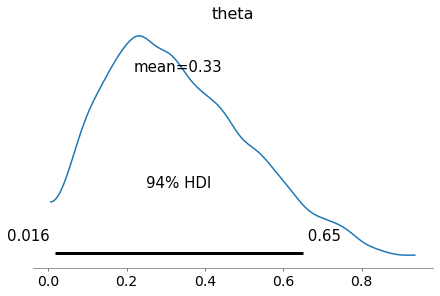

In [5]:
az.plot_posterior(trace)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

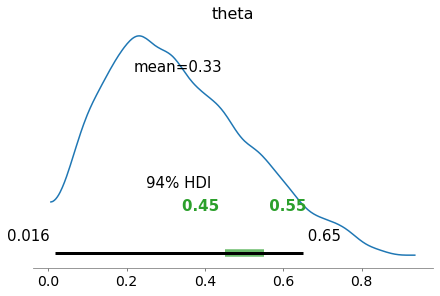

In [6]:
az.plot_posterior(trace, rope=[0.45, .55])

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

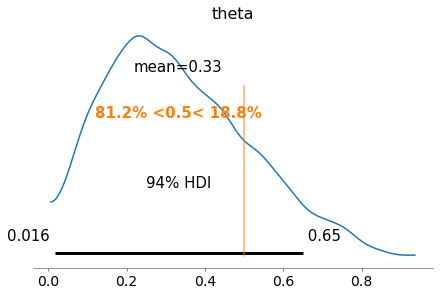

In [7]:
az.plot_posterior(trace, ref_val=0.5)

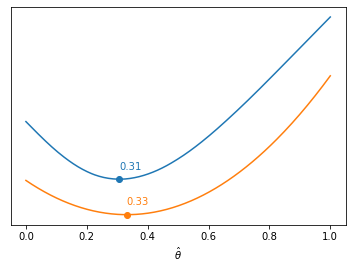

In [8]:
import matplotlib.pyplot as plt
grid = np.linspace(0, 1, 200)
theta_pos = trace['theta']
lossf_a = [np.mean(abs(i - theta_pos)) for i in grid]
lossf_b = [np.mean((i - theta_pos)**2) for i in grid]
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
        (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

In [13]:
np.mean(theta_pos)
np.median(theta_pos)


0.30799294354430506

ValueError: x and y must have same first dimension, but have shapes (200,) and (1,)

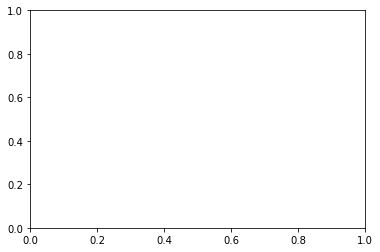

In [14]:
# does not work currently (fix later). 
lossf = []
grid = np.linspace(0, 1, 200)

for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * theta_pos / np.abs(i - theta_pos))
    else:
        f = np.mean(1 / (i - theta_pos))
        
    lossf.append(f)
    mini = np.argmin(lossf)
    plt.plot(grid, lossf)
    plt.plot(grid[mini], lossf[mini], 'o')
    plt.annotate('{:.2f}'.format(grid[mini]),
        (grid[mini] + 0.01, lossf[mini] + 0.1))
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

In [15]:
# need to somehow find the files he is working with. 
# a lot of the bayesian code missing here.

In [16]:
# \theta + tab magic. 
σ = 1
θ = 2
σ + θ

3

In [24]:
np.mean(stats.t(loc=0, scale=1, df=100).rvs(100)) # as df --> large, output --> small. 


-0.04537322148107426

(-5.0, 5.0)

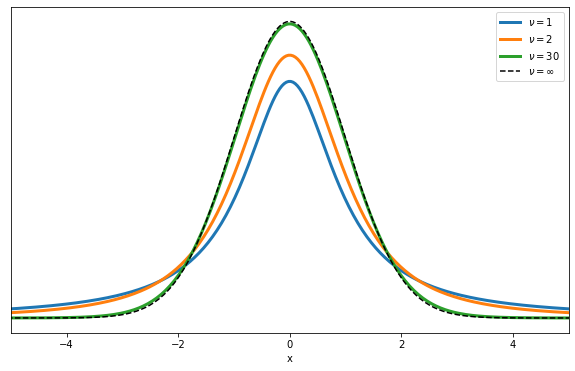

In [26]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)
x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

In [ ]:
## again, some bayesian stuff missing..

# Multilevel Models

In [27]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-
G_samples[i]]))

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'κ'}>,
        <AxesSubplot:title={'center':'κ'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

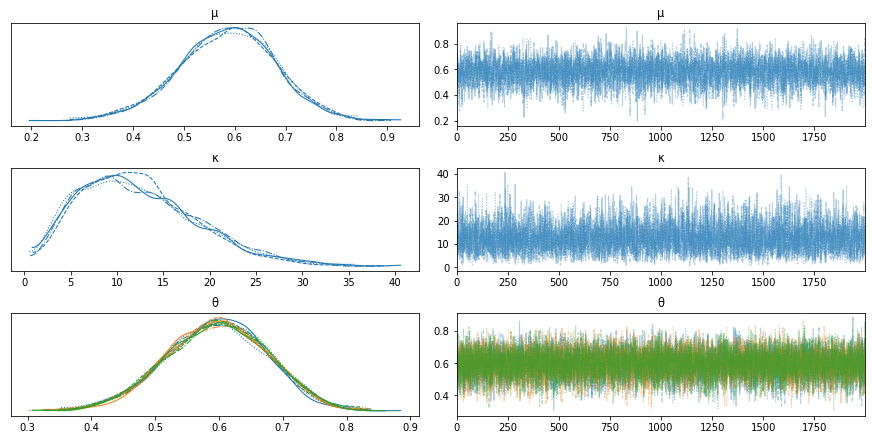

In [28]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)
    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
    trace_h = pm.sample(2000)
az.plot_trace(trace_h)

In [29]:
az.summary(trace_h)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,0.585,0.097,0.408,0.775,0.001,0.001,5127.0,5046.0,5113.0,4880.0,1.0
κ,12.348,6.310,2.036,23.758,0.088,0.062,5148.0,5104.0,4820.0,4583.0,1.0
θ[0],0.596,0.080,0.443,0.743,0.001,0.001,6080.0,6040.0,6078.0,5697.0,1.0
θ[1],0.597,0.079,0.456,0.747,0.001,0.001,5789.0,5726.0,5788.0,5646.0,1.0
θ[2],0.597,0.080,0.452,0.749,0.001,0.001,6215.0,6112.0,6177.0,4886.0,1.0
